# Lang Chain & Lang Graph

Ce notebook est à la fois l'énoncé du TP et un moyen d'éxécuter directement votre code sur l'environnement proposé par Google Colab.

- Commencez par créer un dossier dédié au TP sur votre propre drive (par exemple, `SFFS/TP_LangGraph`) puis copiez-y ce notebook (Fichier > Enregistrer une copie dans drive). **- Option recommandée, nécessite un compte Google**

- Si vous préférez, vous pouvez plutôt travailler en local (téléchargez alors simplement le dossier `TP_LangGraph` complet) **- Charge à vous de gérer les éventuelles différences entre votre environnement et celui pour lequel ce TP est conçu**



Ce TP vise à vous familiariser avec les concepts et l'implémentation d'applications basées sur des LLM et des agents IA. Nous explorerons l'utilisation de Python, de la bibliothèque LangChain pour l'intégration de LLM et d'outils, et de LangGraph pour l'orchestration de workflows multi-agents sous forme de graphes.

Voici le déroulé du tp :
Nous découvrirons tout d'abord comment créer des outils simples (comme une calculatrice) et les intégrer dans des chaînes pour permettre au LLM d'effectuer des tâches spécifiques.
Puis nous mettrons en place des agents IA, et nous introduirons également LangSmith pour le traçage et le débogage de nos applications.
Et pour finir, nous construirons une application multi-agents avec LangGraph pour assister les techniciens d'usine.



## 1) Avant de commencer

**(N'exécutez les 2 prochaines cellules que si, comme recommandé, vous utilisez ce notebook dans Google Colab**). Commençons par monter le dossier dans Colab et copier les dépendances nécessaires au TP, dans un dossier `resources`à côté de ce notebook :

In [ ]:
# from google.colab import drive
# import os

# # Si nécessaire, remplacez par l'emplacement du dossier contenant ce notebook au sein de votre drive
# path = 'SFFS/TP_LangGraph'

# # Monter le dossier dans Google Colab
# drive.mount('/content/drive')
# os.chdir(f'/content/drive/MyDrive/{path}')
# os.getcwd()

In [ ]:
# Copier le contenu du dossier `resources` à côté du notebook, dans votre drive (comme Google Drive ne permet pas de copier des dossiers directement)
# A ne faire que si vous exécutez ce notebook POUR LA 1ERE FOIS, ET AVEC GOOGLE COLAB
# !gdown --folder "https://drive.google.com/drive/folders/1atbNPJCxeU5o2Mdlzf1ioKRJi5qc2WCR?usp=sharing" -O ./resources

# print(os.listdir()) # devrait afficher ['resources', 'LangGraph.ipynb']

Pour afficher les résultats correctement par la suite, ajustons la configuration du notebook :

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none" # désactiver l'affichage de la variable à la dernière ligne de chaque cellule

Il faut ensuite installer les dépendences Python nécessaires et configurer notre LLM.

Commençons par **installer LangChain :**

In [ ]:
# Installer LangChain (ignorez des erreurs de type "pip's dependency resolver does not currently take into account all the packages that are installed")
%pip install --quiet langchain langchain-community

Ensuite, LangChain nécessite qu'on lui fournisse un [endpoint](https://docs.langchain.com/oss/python/integrations/providers/overview#popular-providers) où il peut accéder à un LLM. Cet endpoint peut correspondre :
- soit à une API, comme celle exposée par OpenAI ou Google,
- soit à un LLM _opensource_ que l'on fait tourner en local.


Par facilité, nous allons utiliser l'**API de Groq** (à ne pas confondre avec Grok, l'IA d'Elon Musk), qui propose un plan gratuit d'utilisation de plusieurs modèles _open source_ (comme llama), avec quelques restrictions sur la version du modèle, les requêtes par minute (RPM), les tokens par minute (TPM) et les requêtes par jour (RPD). Vous pouvez retrouver les restrictions ici : https://console.groq.com/docs/rate-limits

Pour commencer, rendez-vous sur le site pour créer une clé : https://console.groq.com/keys. N'oubliez pas de la stocker quelque part.

Ensuite, il suffit de la renseigner ici, en exécutant cette cellule :

In [ ]:
GROQ_API_KEY = input()

# Nettoyer la sortie de la cellule par précaution
from IPython.display import clear_output
clear_output()
print(f"Clé enregistrée : {GROQ_API_KEY[:2]}...{GROQ_API_KEY[-2:]}")

Pour ce TP, nous vous proposons d'utiliser `qwen/qwen3-32b` (https://huggingface.co/Qwen/Qwen3-32B). Ce modèle :
- peut prendre en entrée un texte allant jusqu'à 131 072 tokens, et produire une sortie allant jusqu'à 40 960 tokens,
- est **multi-langues** (vous pouvez donc lui parler en français, anglais, chinois, C++...),
- supporte le raisonnement,
- a des limites d'utilisations assez généreuses, sur Groq.


In [ ]:
model_name = "qwen/qwen3-32b"

Installons la librairie de LangChain requise pour **accéder à l'API de Groq :**


In [ ]:
# Nécessaire pour brancher un LLM exposé par l'API de Groq à LangChain
%pip install --quiet langchain-groq

**Instancions notre LLM** et **vérifions qu'il fonctionne correctement :**

In [ ]:
# Créer un LLM connecté à l'API
from langchain_groq import ChatGroq
llm = ChatGroq(
    model=model_name,
    groq_api_key=GROQ_API_KEY,
    reasoning_effort="none", # désactiver le raisonnement
    model_kwargs={"seed": 42, "top_p": 1e-30} # pour garantir la reproductibilité
)

# Une petite fonction qui passe une entrée au LLM et renvoie la sortie
from IPython.display import display, Markdown
def invoke(llm: ChatGroq, input: str, display_output: bool = False):
  output = llm.invoke(input).content

  # Pour se faire plaisir, afficher la sortie en markdown (format souvent privilégié par ce LLM)
  if display_output:
    display(Markdown(output))

  return output

In [ ]:
# Poser une question au LLM pour vérifier que tout fonctionne
test_input = "Quelles sont les capitales de l'Australie, du Canada, du Brésil et de l'Afrique du Sud ?"
invoke(llm, test_input, display_output=True)

Pour finir, installons LangGraph :

In [ ]:
# Installer langGraph
%pip install --quiet langgraph

Maintenant que tout est prêt, nous allons construire pas-à-pas notre première application basée sur des agents !

## 2) Nos premiers outils et chaînes

Documentation en cas de pépin : https://python.langchain.com/docs/how_to/tools_prompting/

Comme vous avez écouté en cours, vous savez que LangChain permet de construire des applications basées sur des **agents**, c'est-à-dire des LLM qui ont accès à certains **outils (tools)** qu'ils peuvent utiliser pour résoudre des problèmes.

Les outils sont des fonctions (en l'occurence, Python) auxquelles a accès l’agent, et qui peuvent par exemple effectuer des calculs, consulter une base de données, faire des appels à des APIs... Un outil ne peut pas déléguer le travail à un autre outil ou agent ; il s’occupe uniquement de retourner un résultat à l’agent qui l'appelle.

Pour ce premier exemple, nous allons fournir une **calculatrice** à notre LLM.

En effet, sans outils de calculs, certaines tâches peuvent être compliquées pour un LLM, dont l'architecture n'est pas conçue pour manipuler efficacement des nombres :

In [ ]:
# Un petit problème de maths (le LLM va essayer de le résoudre SANS puis AVEC une calculatrice à sa disposition)
puzzle1 = "Si le nombre de bactéries augmente de 95 % chaque heure, par quel facteur sera multiplié la population initiale après 10h ?"

print(f"Réponse attendue : {1.95**10}")

In [ ]:
invoke(llm, puzzle1, display_output=True)

Le LLM semble utiliser la bonne formule, mais se trompe complètement sur l'application numérique.

Maintenant, essayons **avec quelques outils de calcul** : `add`, `multiply` et `exponentiate` qui permettent de calculer respectivement une addition, un produit et une puissance (nous aurions pu ajouter d'autres opérations comme la division, le modulo...) :

In [ ]:
from langchain_core.tools import tool

@tool
def add(number1: float, number2: float) -> float:
   """Computes number1+number2, i.e. add the first argument to the second argument."""
   return number1 + number2

@tool
def multiply(number1: float, number2: float) -> float:
   """Computes number1*number2, i.e. multiply the first argument by the second argument."""
   return number1 * number2

@tool
def exponentiate(base: float, power: float) -> float:
   """Computes base^power, i.e. raises the first argument to the power of the second argument."""
   return base ** power

tools = [add, multiply, exponentiate]

**Important :** Notez
- le décorateur `@tool` au dessus de chaque fonction,
- le commentaire qui décrit chaque fonction,
- les annotations de types des arguments et des valeurs retournées,

Ces indications sont utilisées par LangChain pour générer une description textuelle des outils, qui sera fournie au LLM pour qu'il puisse décider de quand/comment intéragir avec eux :

In [ ]:
# Générer une description textuelle des outils
from langchain_core.tools import render_text_description

rendered_tools = render_text_description(tools)
print(rendered_tools)

In [ ]:
# Créer un prompt système incluant le contexte, la description des outils et des règles de formatage
from langchain_core.prompts import ChatPromptTemplate

system_prompt = """\
You are an assistant that has access to the following set of tools.
Here are the names and descriptions for each tool:

{rendered_tools}

Given the user input, return the name and input of the tool to use.
Return your response as a JSON blob with 'name' and 'arguments' keys.

The `arguments` should be a dictionary, with keys corresponding to the argument names and the values corresponding to the requested values.
"""

prompt = ChatPromptTemplate.from_messages(
    [("system", system_prompt.format(rendered_tools=rendered_tools)),
     ("user", "{input}")]
)

In [ ]:
# Définissons une pipeline LangChain (aussi appelée "chaîne") : créer le prompt (prompt système + input de l'utilisateur) -> le fournir au LLM
chain = prompt | llm

À ce stade là, le LLM devrait maintenant :
- avoir accès à la description des outils `add`, `multiply` et `exponentiate`
- comprendre qu'il faut appeler `exponentiate` au moment de l'application numérique

In [ ]:
# Invoquons la pipeline sur le même problème
invoke(chain, puzzle1, display_output=True)

=> Au lieu de retourner du texte, notre chaîne retourne maintenant un objet JSON qui appelle l'un des outils que nous avons défini, dans un format standard, avec les bons paramètres !

=> Cet appel à l'outil n'a pas été traité, car la chaîne actuelle ne fait que produire cet appel, à partir du prompt système et du problème de maths.

Il ne reste plus qu'à ajouter 2 étapes à la pipeline :
- Parser le JSON produit par le LLM
- "Router" l'appel produit vers le bon outil

In [ ]:
# Etape de parsing JSON
from langchain_core.output_parsers import JsonOutputParser

In [ ]:
# Etape de routage vers le bon outil
from typing import Any, Dict, Optional, TypedDict
from langchain_core.runnables import RunnableConfig

class ToolCallRequest(TypedDict):
    """Un appel à un outil, dans le format produit par le LLM"""
    name: str
    arguments: Dict[str, Any]

def invoke_tool(tool_call_request: ToolCallRequest, config: Optional[RunnableConfig] = None):
    """Une fonction qui appelle le bon outil à partir d'un "appel" en JSON.

    Args:
        tool_call_request: l'appel produit par le LLM (doit correspondre à un outil existant, avec les bons arguments)
        config: la configuration utilisée par LangChain, qui contient des trucs comme des callbacks, des métadonnées...

    Returns:
        sortie de l'outil
    """
    tool_name_to_tool = {tool.name: tool for tool in tools}
    name = tool_call_request["name"]
    requested_tool = tool_name_to_tool[name]
    return requested_tool.invoke(tool_call_request["arguments"], config=config)

In [ ]:
# Mettre à jour la chaîne pour avoir toutes les étapes
chain = prompt | llm | JsonOutputParser() | invoke_tool

**L'heure de vérité :**

In [ ]:
print(f"Problème : '{puzzle1}'")
print(f"Réponse attendue : {1.95**10}")
print(f"Réponse de la chaîne complète : {chain.invoke(puzzle1)}")

Et, pour un autre problème faisant intervenir une multiplication :

In [ ]:
puzzle2 = "Si une tomate pèse 184.48376 grammes, combien pèsent 417453 tomates ?"
print(f"Problème : '{puzzle2}'")
print()

print(f"Réponse attendue : {417453*184.48376:_}")
print()

print("Réponse SANS les outils :")
invoke(llm, puzzle2, display_output = True)
print()

print("Réponse AVEC les outils :")
print(f"{chain.invoke(puzzle2):_}")

**À vous de jouer !**

Pourquoi s'arrêter en si bon chemin ? Complétez le code pour ajouter un 4e outil permettant à la chaîne de résoudre le problème suivant :

In [ ]:
# Problème à résoudre
puzzle3 = "Combien vaut ln(456789451.32194846) ?"
print(f"Problème : '{puzzle3}'")
print()

# Solution correcte
from math import log
print(f"Réponse attendue : {log(456789451.32194846)}")
print()

# Réponse du LLM sans outils
print("Réponse SANS les outils :")
invoke(llm, puzzle3, display_output = True)
print()

# Répose de la chaîne en l'état
print("Réponse AVEC les outils ACTUELS :")
from langchain_core.exceptions import OutputParserException
try:
  print(chain.invoke(puzzle3))
except:
  print("Le modèle n'a pas appelé d'outil correctement.")

In [ ]:
from math import log

# TODO : implémenter l'outil ln (inspirez-vous des outils déjà créés)
@tool
def ln(x: float) -> float:
   """Computes ln(x), i.e. raises the natural logarithm of the argument."""
   return log(x)

# Ajouter l'outil
tools = [add, multiply, exponentiate, ln]

# Mettre à jour le prompt avec la nouvelle description des outils
rendered_tools = render_text_description(tools)
prompt = ChatPromptTemplate.from_messages(
    [("user", system_prompt.format(rendered_tools=rendered_tools)),
     ("user", "{input}")]
)

# Mettre à jour la chaîne
chain = prompt | llm | JsonOutputParser() | invoke_tool

In [ ]:
# Afficher le résultat avec le nouvel outil
print("Réponse AVEC TOUS LES OUTILS (add, multiply, exponentiate, ln) :")
print(chain.invoke(puzzle3))

## 3) Notre premier agent & Introduction à LangSmith

Jusqu'à présent nous utilisons des chaînes, qui sont conçues pour éxécuter une seule passe d'un chemin linéaire et déterministe ; en l'occurence :

`Passer un prompt -> Produire une réponse -> Parser le JSON -> Retourner le retour de l'outil appelé`

Cette architecture limitée ne permet pas de faire face à des cas d'usage plus complexes, nécessitant de définir un flux dynamique, avec des boucles, des conditions et des transitions entre plusieurs états.

Par exemple, comment gérer le cas où le problème ne nécessite pas d'outils ou est mal posé ? Et que faire si le problème nécessite de calculer des résultats intermédiaires, et donc d'appeler les outils plusieurs fois, en cascade ?

Par exemple :

In [ ]:
puzzle4 = "À un taux d'intérêt annuel de 95 %, quelle serait la valeur de 417453 € dans 10 ans ?"
print(f"Problème : {puzzle4}")
print()

print(f"Réponse attendue : {417453 * (1.95**10):_}")
print()

print("Réponse de la CHAÎNE ACTUELLE :")
print(f"{chain.invoke(puzzle4):_}")

La chaîne a simplement produit un résultat intermédiaire (l'exponentiation), et n'est pas assez souple pour permettre au LLM de poursuivre son raisonnement (multiplier ce nombre par le montant initial, 417453).

Pour passer outre ces limitations, nous devons passer d'une chaîne à un vrai **agent**.

Un agent LangGraph est une entité "guidée" par un LLM : en recevant une tâche, il analyse le contexte (la question et l’historique) et décide de l’action à effectuer. Il peut :
- appeler l'un de ses outils,
- transmettre la tâche à un autre agent (nous verrons cela plus tard),
- donner une réponse finale.

In [ ]:
# Prompt système : encourage l'agent à agent à adopter une personnalité de mathématicien qui décompose les problèmes
system_prompt = """You are an expert mathematician and problem solver.
When faced with a word problem (like finance, physics, etc.), your goal is to:
1. Identify the mathematical formula required.
2. Break down that formula into simple arithmetic steps (add, multiply, power).
3. Use the available tools sequentially to solve it.

Do not say you cannot do it because of the topic. If it involves numbers, you can solve it using your math tools."""

# Instancier l'agent
# (à partir de maintenant, on utilisera la fonction create_agent qui crée un objet qui gère déjà le parsing et l'appel d'outils en cascade)
from langchain.agents import create_agent
agent = create_agent(llm, tools, system_prompt=system_prompt)

# Fonction pour passer un problème à l'agent et retourner toutes les étapes
def invoke_agent(agent, input, display_last_output = False):
  response = agent.invoke({"messages": [("user", puzzle4)]}) # contient toutes les réponses

  if display_last_output: # Afficher le dernier message en markdown
    display(Markdown(response["messages"][-1].content))

  return response

In [ ]:
# Même problème
print(f"Problème : {puzzle4}")
print()

# Soumettre le problème à l'agent
print("Réponse de l'agent:")
response = invoke_agent(agent, puzzle4, display_last_output = True)

Le bon résultat est maintenant trouvé !

Pour comprendre comment l'agent créé par LangChain (via la fonction `create_agent`) fonctionne en interne, regardons l'historique des outils appelés :

In [ ]:
# Affichage des étapes (pour comprendre le raisonnement)
for message in response["messages"]:
  if message.type == "ai" and message.tool_calls:
    print(f"- L'IA décide d'appeler l'outil '{message.tool_calls[0]['name']}' avec {message.tool_calls[0]['args']}")
  elif message.type == "tool":
    print(f"\t=> Résultat de l'outil : {message.content}")

Pour avoir le détail des entrées/sorties du LLM à chaque étape, et avoir un aperçu clair de l'activité de nos agents (très utile dans des systèmes plus complexes), nous pouvons utiliser **LangSmith**.

Pour ce faire, créez un compte sur https://smith.langchain.com/ (vous pouvez le faire via votre compte Google, votre compte GitHub ou simplement par email).

Dans le panneau de gauche, cliquez sur "Settings" puis "API Keys" et créez un "Personal Access Token" dans le "Workspace 1".

Renseignez la clé ici, en exécutant cette cellule :

In [ ]:
LANGSMITH_KEY = input()

# Nettoyer la sortie de la cellule par précaution
from IPython.display import clear_output
clear_output()
print(f"Clé enregistrée : {LANGSMITH_KEY[:2]}...{LANGSMITH_KEY[-2:]}")

# Configurer l'environnement
import os
os.environ["LANGCHAIN_API_KEY"] = LANGSMITH_KEY
os.environ["LANGCHAIN_PROJECT"] = "TP LangGraph"


Ensuite, revenez à l'accueil et cliquez sur "Tracing Projects" et entrez dans le projet créé par défaut. Ici, vous aurez accès à toutes les invocations d'agents que vous effecturez, dès lors que vous activez le traçage :

In [ ]:
from langchain_core.tracers.context import tracing_v2_enabled
with tracing_v2_enabled():
  response = invoke_agent(agent, puzzle4, display_last_output = True)

La trace devrait maintenant être visible sur le site de LangSmith. En cliquant dessus, vous pouvoir voir le détail des entrées/sorties et appel d'outils à chaque étape de la résolution du problème, ainsi que les modèles, coûts et latences associés.
Essayez de bien comprendre chaque étape de l'execution visible sous LangSmith et vérifiez que vous obtenez bien ce qui était prévu.

LangSmith comporte plein d'autres fonctionnalités intéressantes, comme le déploiement et le monitoring d'applications LangChain/LangGraph : https://docs.langchain.com/langsmith/home

## 4) Notre première application LangGraph

Nous avons vu comment construire **UN** agent fonctionnel avec plusieurs outils à sa disposition. Nous allons maintenant construire une réelle application LangGraph, multi-agents. C'est un graphe où :
- 1 noeud = 1 agent (avec un ensemble d'outils à disposition)
- 1 arête = 1 "passage de main" qu'un agent peut décider d'opérer vers un autre.

=> **MAIS :** Pourquoi s'embêter à créer plusieurs agents, au lieu de simplement continuer d'ajouter davantage d'outils divers et variés (recherche internet, exécuteur de requêtes SQL...) à un unique agent, pour en faire un couteau suisse autosuffisant ?

Passer d'un agent à une application multi-agents est souvent préférable car :
- On peut associer à chaque agent un prompt spécifique, pour que chacun soit spécialisé dans un aspect de l'application (ex : un expert des maths + un administrateur SQL + ...)
- Le "cloisonnement" des tâches permet d'alléger le nombre d'outils et le contexte à fournir à chaque agent (=> réduction du coût et des hallucinations dues à la longueur des prompts)
- Les agents peuvent agir en parallèle (=> diminution de la latence)
- La structure en graphe facilite la mise en oeuvre de certains patrons de conception (_design pattern_), comme la **_reflection_** :

![Alt text](https://www.baihezi.com/mirrors/langgraph/tutorials/reflection/img/reflection.png)

Nous allons créer une application LangGraph qui servira d'**assistant à des techniciens chargés de maintenir et réparer les différentes machines d'une usine.**

L'assistant pourra :
- consulter une base SQLite contenant les caractéristiques des machines et les journaux des précédentes interventions,
- s'appuyer sur un corpus de guides d'utilisation des machines.

Toutes les données (fictives) existent déjà, dans le dossier `resources`.

In [ ]:
from resources.utils import display_database

display_database("resources/maintenance.db")

### 4.1) État partagé

Tout d'abord, définissons **l'état partagé**, une structure de donnée partagée entre les noeuds, qui représente l'état courant de l'application :

In [ ]:
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    #TODO Ajoutez un attribut 'next' de type string. IL sera utilisé plus tard pour stocker le nom du prochain noeud.
    next: str

    #TODO Ajoutez un attribut 'messages', de type list[BaseMessage], avec un réducteur dont la fonction de réduction est 'operator.add' (voir cours).
    messages: Annotated[list[BaseMessage], operator.add]

### 4.2) Agents

Ensuite, créons les 3 agents de l'application, un par un :

1) **Un agent SQL, qui peut lire, ajouter ou supprimer les données dans les 2 tables SQL suivantes :**
```sql
CREATE TABLE machines (
    machine_id INTEGER PRIMARY KEY AUTOINCREMENT,
    model_name TEXT,
    install_date TEXT,
    end_of_warranty_date TEXT,
    warranty_active BOOLEAN
);

CREATE TABLE maintenance_logs (
    log_id INTEGER PRIMARY KEY AUTOINCREMENT,
    FOREIGN KEY(machine_id) REFERENCES machines(machine_id),
    date TEXT,
    issue TEXT,
    solution TEXT,
    cost INTEGER
);
```

Base de données :

In [ ]:
import sqlite3
from sqlalchemy import create_engine, event
from langchain_community.utilities import SQLDatabase

# Chemin de la base de données (déjà créée !), depuis le notebook
database_relative_path = "resources/maintenance.db"

# Blacklistons certains types de requêtes pour empêcher l'agent de faire n'importe quoi
def sqlite_authorizer(action_code, table, column, sql_main, trigger):
    """
    Politique de sécurité "Blacklist" :
    On autorise tout par défaut, sauf ce qui est explicitement interdit.
    """
    # Codes d'action SQLite
    SQLITE_DELETE = 9       # Suppression de lignes
    SQLITE_DROP_TABLE = 11  # Suppression de table
    SQLITE_ALTER_TABLE = 26 # Modification de structure
    SQLITE_UPDATE = 23      # Mise à jour

    # Supression de données, altération du schéma : interdit
    if action_code in [SQLITE_DELETE, SQLITE_DROP_TABLE, SQLITE_ALTER_TABLE]:
        return sqlite3.SQLITE_DENY

    # Interdit de modifier des logs
    if table == "maintenance_logs" and action_code == SQLITE_UPDATE:
            return sqlite3.SQLITE_DENY

    # On autorise le reste
    return sqlite3.SQLITE_OK


engine = create_engine(f"sqlite:///{database_relative_path}")

@event.listens_for(engine, "connect")
def connect(dbapi_connection, connection_record):
    """
    À chaque connexion physique à la DB, on active l'authorizer.
    """
    # dbapi_connection est l'objet sqlite3 pur
    dbapi_connection.set_authorizer(sqlite_authorizer)

db = SQLDatabase(engine=engine)

Outils nécessaires pour notre agent SQL (déjà implémentés par LangChain !) :

In [ ]:
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()
print("Outils de l'agent SQL :")
for sql_tool in tools:
  print(f"- {sql_tool.name}")

Sécurisons l'outil de requête SQL afin de faire valider toute requête autre que "SELECT" par l'utilisateur (Man In The Loop) :

In [ ]:
from langgraph.types import Command, interrupt
from langchain_core.tools import tool

raw_sql_tool = tools[0]

@tool
def sql_db_query(query: str) -> str:
  """Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields."""
  is_read_only=query.strip().upper().startswith("SELECT")

  if not is_read_only:
        # Cela met le graphe en pause et renvoie la valeur à l'utilisateur
        # L'utilisateur devra répondre pour reprendre l'exécution (Man in the loop)
        human_review = interrupt({
            "query": query,
            "warning": "Cette requête va modifier la base de données. Approuver ?"
        })

        action = human_review.get("action", "reject")

        if action != "approve":
            return f"Action rejetée par l'utilisateur. La requête '{query}' n'a pas été exécutée."

  try:
      return raw_sql_tool.invoke(query)
  except Exception as e:
      return f"Erreur SQL: {e}"

tools[0] = sql_db_query

Créer l'agent SQL :

In [ ]:
from langchain.agents import create_agent
sql_system_prompt = """# CONTEXTE
Tu es admin d'une base de données SQLite, qui contient des informations sur les machines de l'usine.

# SCHÉMA RELATIONNEL
Tu as accès aux tables suivantes (noms d'attributs en anglais, contenu en français) :
  - machines (machine_id INTEGER, model_name TEXT, install_date TEXT, end_of_warranty_date TEXT, warranty_active BOOLEAN)
  - maintenance_logs (log_id INTEGER, machine_id FOREIGN KEY, date TEXT, issue TEXT, solution TEXT, cost INTEGER)

# WORKFLOW
1) Commence par déterminer où se trouvent les informations dont tu as besoin.
2) Ensuite, écris puis exécute la ou les requêtes SQL appropriées
- Quand tu filtres via un string fourni par l'utilisateur (ex : model_name), sois permissif : utilise 'LIKE' et ne sois PAS sensible à la casse.
- Pour trouver le machine_id à partir du model_name, n'utilise pas 'LIMIT 1', pour t'assurer qu'il n'y a pas de doublons.
3) Enfin, rédige tes conclusions de façon concise :
- Ne donne que les informations demandées, pas le résultat complet de tes requêtes.
- Sois transparent si tu ne trouves pas certaines données demandées. N'invente rien, si une requête échoue ou ne renvoie rien, dis-le.
- Relève toute ambiguïté (ex : tu devais identifier une machine appelée "Presse hydraulique" et plusieurs machine_id correspondent à ce model_name).
"""
#TODO créez l'agent sql_agent avec les bons paramètres. Pour cela utlisez create_agent.
sql_agent = create_agent(
    model=llm,
    tools=tools,
    system_prompt=sql_system_prompt
)

# Encapsuler l'agent dans un noeud
def sql_agent_node(state: AgentState):
  result = sql_agent.invoke(state)

  # On récupère le dernier message (ie le rapport que fait l'agent SQL au superviseur)
  last_message = result["messages"][-1]

  return {
      "messages": [AIMessage(content=last_message.content, name="Troubleshooter")]
  }

2) **Un agent RAG, qui peut exploiter un corpus de documents textuels (guides d'utilisation des machines) :**

In [ ]:
# Dépendance nécessaire pour indexer la base de données pour faire du RAG
%pip install --quiet langchain-huggingface

Création d'une base de données en mémoire (dans la vraie vie, on utiliserait bien-sûr une base de données externe au lieu de tout charger en mémoire) :

In [ ]:
import os
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_core.tools import tool

# Chemin des documents
DOCS_PATH = "./resources/user_guides"

# Chemin du modèle d'embedding (permet d'indexer la base RAG)
LOCAL_MODEL_PATH = "./resources/embedding_model"

# Chargement des documents
loader = DirectoryLoader(DOCS_PATH, glob="**/*", loader_cls=TextLoader)
docs = loader.load()

# Chunking
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\n\n", "\n", " ", ""] # Essaie de couper aux paragraphes d'abord
)
splits = text_splitter.split_documents(docs)

# Embedding (on utilise le modèle déjà téléchargé dans ./resources/embedding_model)
embeddings = HuggingFaceEmbeddings(
    model_name=LOCAL_MODEL_PATH,
    model_kwargs={'device': 'cpu'},
    encode_kwargs={'normalize_embeddings': False}
)

# Instanciation du vector store en mémoire
vector_store = InMemoryVectorStore.from_documents(
    documents=splits,
    embedding=embeddings
)

Outil de RAG :

In [ ]:
@tool
def retrieve_technical_docs(query: str):
    """
    Search the technical documentation for machines (manuals, procedures, safety).
    Use this tool to find:
    - Repair protocols
    - Error codes
    - Safety instructions
    - Technical specifications

    Args:
        query: The question or search keywords, in French (e.g., “comment changer joint presse hydraulique”)
    """
    # Recherche des 3 documents les plus pertinents
    results = vector_store.similarity_search(query, k=3)

    # Construction de la réponse formatée pour le LLM
    context = ""
    for i, doc in enumerate(results):
        source = doc.metadata.get('source', 'Inconnu').split('/')[-1]
        context += f"\n--- EXTRAIT {i+1} (Source: {source}) ---\n{doc.page_content}\n"

    return context

Créer l'agent RAG :

In [ ]:
rag_system_prompt = """Tu es spécialiste en documentation technique pour la maintenance de machines en usine.
Ton rôle est d'aider les techniciens en recherchant des informations précises dans les guides d'utilisation des machines.

Directives :
- Utilise **TOUJOURS** l'outil pour répondre aux questions techniques. Ne te fie pas à tes connaissances internes.
- Concentre-toi sur l'**exécution** des tâches (comm "Comment remplacer le ventilateur ?") et non sur le diagnostic (comme "Pourquoi y a-t-il une surchauffe ?").
- Si l'outil renvoie des avertissements de sécurité (par exemple, LOTO, haute tension), mentionne-les explicitement en premier lieu.
- Si le document ne contient pas la réponse, indique clairement que la procédure ne figure pas dans le manuel.
"""
#TODO créez l'agent rag_agent avec les bons paramètres. Pour cela utlisez create_agent.
rag_agent = create_agent(
    model=llm,
    tools=[retrieve_technical_docs],
    system_prompt=rag_system_prompt
)

# Encapsuler l'agent dans un noeud
def rag_agent_node(state: AgentState):
    result = rag_agent.invoke(state)
    last_message = result["messages"][-1]

    return {
        "messages": [AIMessage(content=last_message.content, name="Technician")]
    }

3) **Un agent superviseur, chargé d'orchestrer les recherches à partir des instructions de l'utilisateur :**

In [ ]:
from typing import TypedDict, Literal, Annotated
import datetime
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

# Classe de sortie (permet de produire une consigne de routage ou une réponse finale)
class SupervisorDecision(TypedDict):
    next: Literal["Troubleshooter", "Technician", "FINISH"]
    instructions: str  # Contiendra soit la consigne pour l'agent, soit la réponse finale

# Prompt
current_date = datetime.date.today().isoformat()

supervisor_system_prompt = f"""# CONTEXTE
Tu es le **l'assistant IA de réparation** d'une usine qui contient des machines à maintenir.
En tant que chatbot, ton objectif est d'aider le technicien humain qui t'interroge pour te demander des informations sur la machine (diagnostic, procédure de réparation...).
Date actuelle : {current_date}

# AGENTS
Pour ce faire, tu as 2 autres agents à ta disposition :
1. **Troubleshooter** (agent SQL) : a accès à la base de données. Il peut te donner l'ID d'une machine à partir de son nom, ses informations de garantie et ses journaux de maintenance (problèmes rencontrés et solutions).
2. **Technician** (agent RAG) : a accès aux manuels d'utilisation des machines. Il peut t'expliquer comment retirer/remplacer une machine et les éventuelles consignes de sécurité.

# RÈGLES DE ROUTAGE (A SUIVRE RIGOUREUSEMENT)
- Quoi qu'il arrive, ton but est de produire une structure JSON avec les champs `next` et `instructions`, pas du texte libre.
- Analyse la conversation et indique le prochain acteur dans le champ `next` : 'Troubleshooter' ou 'Technician'. Donne lui les instructions/contexte nécessaire à sa tâche dans le champ `instructions`.

**CAS SPÉCIAL : RÉPONSE FINALE**
Si tu as recueilli toutes les informations nécessaires, veut demander des clarifications à l'utilisateur ou répond à une question non technique (ex : "Qui es-tu ?") :
  1. Choisis impérativement **'FINISH'** pour le champ `next`.
  2. Écris ta réponse à l'utilisateur (ex: "Je suis l'assistant de maintenance...") DANS le champ `instructions`.

# MÉTHODOLOGIE
Suis ce workflow :

**ÉTAPE 1 : CLARIFIER OU INFORMER**
- L'utilisateur peut ne rien demander (ex : 'Bonjour !') ou être trop vague (ex : ne pas citer quelle machine a un problème ou comment la panne se manifeste). Si c'est le cas, fais `FINISH` et demande des clarifications.

**ÉTAPE 2 : IDENTIFIER LA MACHINE**
- Demande au `Troubleshooter` :
  - Si l'utilisateur a déjà fourni le machine_id, de vérifier qu'il existe et que les informations sur cette machine correspondent bien à celles décrites par l'utilisateur.
  - Si l'utilisateur n'a fourni qu'un nom de machine (ex : 'Presse hydraulique'), de trouver le machine_id correspondant.
- Si nécessaire, fais `FINISH` et demande des clarifications (ex : si plusieurs IDs correspondent au nom de machine fourni par l'utilisateur, demander des informations supplémentaires pour lever l'ambiguïté).

**ÉTAPE 3 : DIAGNOSTIC**
- Une fois la machine identifiée, demande au `Troubleshooter` de :
  - Vérifier si la machine est actuellement sous garantie
  - Regarder si des symptômes similaires sont mentionnés dans les 5 derniers journaux de maintenance de cette machine
- Enfin, identifie la cause probable et la solution standard sur la base des journaux passés.

**ÉTAPE 4 : EXÉCUTION ET SÉCURITÉ**
Si une réparation est nécessaire (ex : "Remplacer le joint torique"), demande au `Technician` de trouver :
  - Les avertissements de sécurité spécifiques (LOTO, EPI).
  - La procédure de remplacement étape par étape pour ce modèle spécifique.

**ÉTAPE 5 : CONCLUSIONS**
- Fais un rapport clair et profesionnel sur tes conclusions (dans la langue de l'utilisateur) : ID de la machine, diagnostic, procédure de réparation, consignes de sécurité.
- Sois transparent sur tes incertitudes voire les informations non trouvées (ex : procédure pour réparer la machine non présente dans le manuel).
"""

prompt = ChatPromptTemplate.from_messages([
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Select 'Troubleshooter', 'Technician', or 'FINISH' in the `next` field."
            "Write your instructions or final answer in the 'instructions' field."
        ),
    ])

# Contenu du noeud Supervisor : chaîne "Prompt -> LLM (Format JSON forcé)"
supervisor_chain = prompt | llm.bind_tools([SupervisorDecision], tool_choice="auto")

def supervisor_node(state: AgentState):
    decision = supervisor_chain.invoke({"messages": state["messages"]})

    # 1er cas : le LLM a produit un JSON comme prévu
    if decision.tool_calls:
      # On renvoie la décision pour le routing ET on ajoute le message du superviseur à l'historique
      tool_args = decision.tool_calls[0]["args"]
      return {
          "next": tool_args.get("next"),
          "messages": [AIMessage(content=tool_args.get("instructions"), name="Supervisor")]
      }

    # 2e cas : le LLM a produit du texte brut
    else:
      return {
          "next": "FINISH",
          "messages": [AIMessage(content=decision.content, name="Supervisor")]
      }

### 4.3) Création de l'application

Pour finir, créons l'application elle-même, en définissant sa typologie (noeuds, transitions). Voici le graphe que l'on souhaite obtenir :
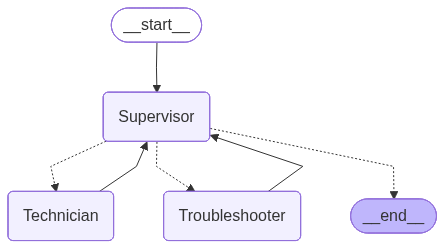


In [ ]:
from langgraph.graph.state import CompiledStateGraph

In [ ]:
from langgraph.graph import StateGraph, START, END

# Créer un graphe vide avec notre état partagé
workflow = StateGraph(AgentState)

# Noeuds
#TODO créer les noeuds Supervisor, Troubleshooter et Technician
workflow.add_node("Supervisor", supervisor_node)
workflow.add_node("Troubleshooter", sql_agent_node)
workflow.add_node("Technician", rag_agent_node)

# Arêtes (transitions entre les agents)
# TODO relier les noeuds entre eux
workflow.add_edge(START, "Supervisor")
workflow.add_edge("Troubleshooter", "Supervisor")
workflow.add_edge("Technician", "Supervisor")

# Logique de sortie du superviseur
workflow.add_conditional_edges(
    "Supervisor",
    lambda state: END if state["next"] == "FINISH" else state["next"],
     {
         "Troubleshooter": "Troubleshooter",
         "Technician": "Technician",
         END: END
    }
)

# Création d'une mémoire qui stockera l'état de l'application
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Compilation de l'application
app = workflow.compile(checkpointer=memory)

# Afficher le graphe pour visualiser le workflow de l'application
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

Vérifiez que le graphe obtenu correspond à celui énoncé plus haut.

### 4.4) Test

C'est le moment de tester l'application ! Une fonction pour afficher de façon jolie une session interactive a déjà été codée dans `resources.utils` .

N'hésitez pas à jouer avec l'application, à tester différents scénarios/entrées :
- Essayer de demander des informations sur le contexte : `"Je suis nouveau dans l'usine. Qui es-tu ?"`
- Essayer d'utiliser l'assistant pour réparer une machine (cas d'usage principal de l'application) : `"La presse hydraulique fuit. Comment la réparer ?"`
- Essayer de demander à l'assistant d'ajouter des données à la base de données pour vérifier que le _Man in the loop_ fonctionne : `"J'ai une nouvelle machine, un extincteur, garanti deux ans. Ajoute-le à la base de données SQL."`
- ...

In [ ]:
from resources.utils import run_app_with_rich

run_app_with_rich(app)

## 5) À vous de jouer

Dans cette partie, vous allez compléter l'application LangGraph en ajoutant quelques fonctionnalités de votre choix !

**Quelques idées :**
1) Équiper l'assistant d'un **moteur de recherche en ligne** (comme DuckDuckGo), pour compléter les données internes (RAG, SQL) par des infos externes (par exemple : le prix d'une pièce de rechange).
2) Fournir à l'assistant un outil de recherche sur **Wikipedia**, pour trouver davantage d'infos techniques.
3) Permettre à l'assistant d'**envoyer un message (discord, mail...)** au technicien humain, contenant un rapport qui synthétise les conclusions de l'assistant.
4) Générer un **graphique** (par exemple : le coût des réparations au cours du temps)

Pour rappel, de nombreux outils et ensembles d'outils (_toolkits_) sont déjà implémentés dans **`langchain_community`** : https://docs.langchain.com/oss/python/integrations/tools

Pour vous lancer, nous vous proposons un squelette de code pour intégrer une fonctionnalité de recherche sur Wikipedia (c'est l'idée n°2).



### 5.1) 3e fonctionnalité : Recherche sur Wikipedia

On va permettre à l'assistant de chercher en ligne des informations techniques précises sur les machines, pièces... à la demande de l'utilisateur.

Pour ce faire, on va utiliser l'outil `WikipediaQueryRun` déjà implémenté dans `langchain_community` :

In [ ]:
%pip install --quiet wikipedia

In [ ]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

# TODO : éventuellement, revenir ici ultérieurement pour tuner les paramètres
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(
    lang="fr", # la langue des pages à considérer
    top_k_results=1, # le nombre de pages dont l'outil affiche le résumé (section en haut de la page)
    doc_content_chars_max=1_000 # rogner le résultat de l'outil (concaténation des résumés des top_k_results premières pages) pour éviter de consommer tous nos crédits
    ))

@tool
def wikipedia_search(query: str) -> str:
    """Recherche une information sur Wikipédia en français et retourne un résumé concis."""
    return wikipedia_tool.invoke(query)

print(wikipedia_tool)

In [ ]:
# Testons l'outil
print(wikipedia_tool.invoke("Chopin"))

Création d'un noeud `WikipediaAgent` dédié à cette fonctionnalité. L'idée est que, sachant que cet agent a accès à Wikipedia, le `Supervisor` puisse décider de lui poser une question technique (par exemple : "Quels sont les 3 standards de dureté Shore ?") ; le `WikipediaAgent` s'occupe de déterminer quelle requête envoyer à Wikipedia et d'extraire/synthétiser l'information pour le `Supervisor`.

In [ ]:
from langchain_community.tools import DuckDuckGoSearchRun

# TODO : rédiger le prompt (contexte, consignes, guidelines).
# Conseil : insister sur le fait de toujours utiliser l'outil pour répondre, sans rien inventer, et d'être transparent sur les informations non trouvées
wikipedia_system_prompt = """TODO
# CONTEXTE
Tu es un assistant expert en recherche d'informations sur Wikipédia.
# RÈGLES
- Utilise **TOUJOURS** l'outil pour répondre aux questions factuelles. Ne te fie pas à tes connaissances internes.
- Si l'outil renvoie une page Wikipédia, résume les informations clés de manière concise.
- Si l'outil ne trouve pas d'information pertinente, indique-le clairement.
# GUIDELINES
- Sois précis et concis dans tes réponses.
- Cite tes sources si possible.
"""

# Création de l'agent
wikipedia_agent = create_agent(
    model=llm,
    tools=[wikipedia_search],
    system_prompt=wikipedia_system_prompt
)


# TODO : Création du noeud encapsulant l'agent (s'inspirer de l'agent SQL ou de l'agent RAG)
def wikipedia_agent_node(state: AgentState):
  result = wikipedia_agent.invoke(state)
  last_message = result["messages"][-1]
  return {
      "messages": [AIMessage(content=last_message.content, name="WikiExpert")]
  }

Mise à jour du superviseur pour inclure cet agent (expliquer dans le prompt ce qu'il fait et quand l'appeler, mettre à jour les consignes de routage...) :

In [ ]:
# Ceci est un copier-coller du code du superviseur, de la partie 4.2.
# Suivez simplement les TODOs

from typing import TypedDict, Literal, Annotated
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

class SupervisorDecision(TypedDict):
    next: Literal["Troubleshooter", "Technician", "WikiExpert", "FINISH"] # TODO : ajouter l'agent
    instructions: str

# Prompt
# TODO : ajuster le prompt pour inclure l'agent
supervisor_system_prompt = f"""# CONTEXTE
Tu es le **l'assistant IA de réparation** d'une usine qui contient des machines à maintenir.
En tant que chatbot, ton objectif est d'aider le technicien humain qui t'interroge pour te demander des informations sur la machine (diagnostic, procédure de réparation...).
Date actuelle : {current_date}

# AGENTS
Pour ce faire, tu as 3 autres agents à ta disposition :
1. **Troubleshooter** (agent SQL) : a accès à la base de données. Il peut te donner l'ID d'une machine à partir de son nom, ses informations de garantie et ses journaux de maintenance (problèmes rencontrés et solutions).
2. **Technician** (agent RAG) : a accès aux manuels d'utilisation des machines. Il peut t'expliquer comment retirer/remplacer une machine et les éventuelles consignes de sécurité.
3. **WikiExpert** (agent Wikipedia) : a accès à Wikipédia pour rechercher des informations générales sur des concepts techniques, des pièces de machines ou des procédures de maintenance.

# RÈGLES DE ROUTAGE (A SUIVRE RIGOUREUSEMENT)
- Quoi qu'il arrive, ton but est de produire une structure JSON avec les champs `next` et `instructions`, pas du texte libre.
- Analyse la conversation et indique le prochain acteur dans le champ `next` : 'Troubleshooter', 'Technician' ou 'WikiExpert'. Donne lui les instructions/contexte nécessaire à sa tâche dans le champ `instructions`.

**CAS SPÉCIAL : RÉPONSE FINALE**
Si tu as recueilli toutes les informations nécessaires, veut demander des clarifications à l'utilisateur ou répond à une question non technique (ex : "Qui es-tu ?") :
  1. Choisis impérativement **'FINISH'** pour le champ `next`.
  2. Écris ta réponse à l'utilisateur (ex: "Je suis l'assistant de maintenance...") DANS le champ `instructions`.

# MÉTHODOLOGIE
Suis ce workflow :

**ÉTAPE 1 : CLARIFIER OU INFORMER**
- L'utilisateur peut ne rien demander (ex : 'Bonjour !') ou être trop vague (ex : ne pas citer quelle machine a un problème ou comment la panne se manifeste). Si c'est le cas, fais `FINISH` et demande des clarifications.
- L'utilisateur peut poser des questions techniques sur des concepts, pièces ou procédures. Si c'est le cas, fais `FINISH` et utilise l'agent `WikiExpert` pour répondre à la question.

**ÉTAPE 2 : IDENTIFIER LA MACHINE**
- Demande au `Troubleshooter` :
  - Si l'utilisateur a déjà fourni le machine_id, de vérifier qu'il existe et que les informations sur cette machine correspondent bien à celles décrites par l'utilisateur.
  - Si l'utilisateur n'a fourni qu'un nom de machine (ex : 'Presse hydraulique'), de trouver le machine_id correspondant.
- Si nécessaire, fais `FINISH` et demande des clarifications (ex : si plusieurs IDs correspondent au nom de machine fourni par l'utilisateur, demander des informations supplémentaires pour lever l'ambiguïté).

**ÉTAPE 3 : DIAGNOSTIC**
- Une fois la machine identifiée, demande au `Troubleshooter` de :
  - Vérifier si la machine est actuellement sous garantie
  - Regarder si des symptômes similaires sont mentionnés dans les 5 derniers journaux de maintenance de cette machine
  - Si nécessaire, demander au `WikiExpert` des informations complémentaires sur des concepts techniques ou des pièces spécifiques mentionnées dans les journaux.
- Enfin, identifie la cause probable et la solution standard sur la base des journaux passés.

**ÉTAPE 4 : EXÉCUTION ET SÉCURITÉ**
Si une réparation est nécessaire (ex : "Remplacer le joint torique"), demande au `Technician` de trouver :
  - Les avertissements de sécurité spécifiques (LOTO, EPI).
  - La procédure de remplacement étape par étape pour ce modèle spécifique.

**ÉTAPE 5 : CONCLUSIONS**
- Fais un rapport clair et profesionnel sur tes conclusions (dans la langue de l'utilisateur) : ID de la machine, diagnostic, procédure de réparation, consignes de sécurité.
- Sois transparent sur tes incertitudes voire les informations non trouvées (ex : procédure pour réparer la machine non présente dans le manuel).
"""

prompt = ChatPromptTemplate.from_messages([
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Select 'Troubleshooter', 'Technician', 'WikiExpert' or 'FINISH' in the `next` field." # TODO : ajouter l'agent
            "Write your instructions or final answer in the 'instructions' field."
        ),
    ])

# Chaine
supervisor_chain = prompt | llm.bind_tools([SupervisorDecision], tool_choice="auto")

# Noeud
def supervisor_node(state: AgentState):
    decision = supervisor_chain.invoke({"messages": state["messages"]})

    if decision.tool_calls:
      tool_args = decision.tool_calls[0]["args"]
      return {
          "next": tool_args.get("next"),
          "messages": [AIMessage(content=tool_args.get("instructions"), name="Supervisor")]
      }

    else:
      return {
          "next": "FINISH",
          "messages": [AIMessage(content=decision.content, name="Supervisor")]
      }

Mise à jour de l'application pour inclure l'agent :

In [ ]:
# Recréer le workflow avec le nouveau noeud Supervisor et le noeud Wikipedia
workflow = StateGraph(AgentState)
workflow.add_node("Supervisor", supervisor_node)
workflow.add_node("Troubleshooter", sql_agent_node)
workflow.add_node("Technician", rag_agent_node)

# TODO : ajouter le noeud au workflow
workflow.add_node("WikiExpert", wikipedia_agent_node)

# TODO : ajouter les bonnes arêtes au workflow
workflow.add_edge("WikiExpert", "Supervisor")
workflow.add_edge(START, "Supervisor")
workflow.add_edge("Troubleshooter", "Supervisor")
workflow.add_edge("Technician", "Supervisor")

# TODO : inclure l'agent dans le conditional_edge
workflow.add_conditional_edges(
    "Supervisor",
    lambda state: END if state["next"] == "FINISH" else state["next"],
     {
         "Troubleshooter": "Troubleshooter",
         "Technician": "Technician",
         "WikiExpert": "WikiExpert",
         END: END
    }
)

On réutilise le code précédent pour compiler l'application :

In [ ]:
# Création d'une mémoire qui stockera l'état de l'application
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Compilation de l'application
app = workflow.compile(checkpointer=memory)

# Afficher le graphe pour visualiser le workflow de l'application
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

Test :

In [ ]:
from resources.utils import run_app_with_rich

run_app_with_rich(app)

**Note :** Il est possible que cela ne marche pas du premier coup et qu'il faille par exemple :
- tuner les paramètres de l'outil (ex : nombre de pages retournées par la recherche),
- tuner les prompts du `WikipediaAgent` et/ou du `Supervisor`, notamment s'ils hallucinent ou ne formatent pas leurs retours correctement (ce qui entraîne une erreur 400),
- etc.

### 5.2) 4e fonctionnalité : à déterminer

Si vous êtes inspiré, reprenez ces mêmes principes pour ajouter un feature de votre choix.

In [ ]:
# TODO